In [1]:
#https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
#>https://github.com/Tony607/Focal_Loss_Keras/blob/master/src/keras_focal_loss.ipynb
#https://www.kaggle.com/ntnu-testimon/paysim1

In [2]:
# %tensorflow_version 1.x
# import tensorflow

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
np.random.seed(42)

In [5]:
# create data frame containing your data, each column can be accessed # by df['column   name']
file_path = os.path.join('/content/gdrive/My Drive/AI/kaggle/', 'PS_20174392719_1491204439457_log.csv')
dataset = pd.read_csv(file_path)
del dataset['nameDest']
del dataset['nameOrig']
del dataset['type']

dataset.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [6]:
dataset['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [7]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu) / sigma

In [8]:
from sklearn.model_selection  import train_test_split
X, y = dataset.iloc[:,:-2], dataset.iloc[:, -2]
print('X:', X)
y = keras.utils.to_categorical(y, num_classes=2)

#X = feature_normalize(X.as_matrix()) #AttributeError: 'DataFrame' object has no attribute 'as_matrix'
X = feature_normalize(X.to_numpy())   #https://stackoverflow.com/questions/60164560/attributeerror-series-object-has-no-attribute-as-matrix-why-is-it-error
print('feature_normalize X:', X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print('X_train.shape:', X_train.shape, ' ,X_test.shape:', X_test.shape)

X:          step      amount  ...  oldbalanceDest  newbalanceDest
0           1     9839.64  ...            0.00            0.00
1           1     1864.28  ...            0.00            0.00
2           1      181.00  ...            0.00            0.00
3           1      181.00  ...        21182.00            0.00
4           1    11668.14  ...            0.00            0.00
...       ...         ...  ...             ...             ...
6362615   743   339682.13  ...            0.00       339682.13
6362616   743  6311409.28  ...            0.00            0.00
6362617   743  6311409.28  ...        68488.84      6379898.11
6362618   743   850002.52  ...            0.00            0.00
6362619   743   850002.52  ...      6510099.11      7360101.63

[6362620 rows x 6 columns]
feature_normalize X: [[-1.70304158e+00 -2.81559923e-01 -2.29810037e-01 -2.37621696e-01
  -3.23813895e-01 -3.33411405e-01]
 [-1.70304158e+00 -2.94767262e-01 -2.81359380e-01 -2.85812295e-01
  -3.23813895e-01 -3.3341

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

model = Sequential()
model.add(Dense(10, input_dim=input_dim, activation='relu', name='input'))
model.add(Dense(20, activation='relu', name='fc1'))
model.add(Dense(10, activation='relu', name='fc2'))
model.add(Dense(nb_classes, activation='softmax', name='output'))


In [10]:
# #########################################
# #1. 기본모델
# ##########################################

# model.compile(loss='categorical_crossentropy',
#               optimizer='nadam',
#               metrics=['accuracy'])

# # from sklearn.utils import class_weight
# # class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = {0 : 1., 1: 20.}
# model.fit(X_train, y_train, epochs=3, batch_size=1000, class_weight=class_weight)

# Train on 5090096 samples
# Epoch 1/3
# 5090096/5090096 [==============================] - 14s 3us/sample - loss: 0.0613 - acc: 0.9985
# Epoch 2/3
# 5090096/5090096 [==============================] - 13s 3us/sample - loss: 0.0402 - acc: 0.9981
# Epoch 3/3
# 5090096/5090096 [==============================] - 13s 3us/sample - loss: 0.0353 - acc: 0.9982

In [12]:
#########################################
#2. Forcal-Loss
##########################################

from tensorflow import keras
import tensorflow as tf

class FocalLoss(keras.losses.Loss):
    def __init__(self, gamma=2., alpha=4.,
                 reduction=keras.losses.Reduction.AUTO, name='focal_loss'):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        """
        super(FocalLoss, self).__init__(reduction=reduction,
                                        name=name)
        self.gamma = float(gamma)
        self.alpha = float(alpha)

    def call(self, y_true, y_pred):
        """
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(
            tf.subtract(1., model_out), self.gamma))
        fl = tf.multiply(self.alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)


model.compile(loss=FocalLoss(alpha=1),
              optimizer='nadam',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=3, batch_size=1000)

Epoch 1/3
5091/5091 [==============================] - 10s 2ms/step - loss: 0.0052 - accuracy: 0.9958
Epoch 2/3
5091/5091 [==============================] - 10s 2ms/step - loss: 0.0012 - accuracy: 0.9993
Epoch 3/3
5091/5091 [==============================] - 10s 2ms/step - loss: 0.0010 - accuracy: 0.9993


In [13]:
score = model.evaluate(X_test, y_test, batch_size=1000)
score

#1.기본모델
# 1272524/1272524 [==============================] - 2s 1us/sample - loss: 0.0110 - acc: 0.9985
# [0.011038452221895432, 0.99853206]

1273/1273 [==============================] - 2s 1ms/step - loss: 9.6803e-04 - accuracy: 0.9993


[0.0009680264629423618, 0.9993210434913635]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


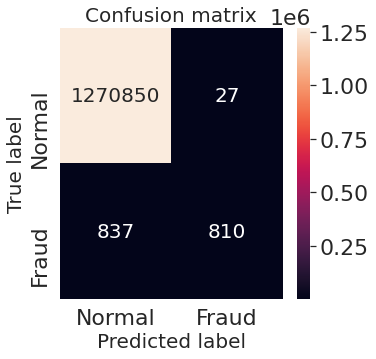

In [14]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
predictions = model.predict(X_test, batch_size=1000)

LABELS = ['Normal','Fraud'] 

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.show()

In [15]:
values = confusion_matrix.view()
error_count = values.sum() - np.trace(values)
error_count
#1.기본모델
#1868

864